## Restricted Boltzmann Machine
 - Restricted    ==> No connections within a layer || But among different layers fully connected
 - KL Divergence ==> Compare actual to recreation
 
 
 ### How can we use RBM to initialize weights?
  - Apply the RBM idea on adjacent two layers as a pre=training step
  - Continue the first process to all layers
  - This will set weights


## Xavier / He Initialization
 - <span style="color:red"><strong>No need to use complicated RBM for weight initializations</strong></span>
 - Simple methods are enough
   - Xavier Init: ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
       - Normal Init
           - $$W ~ N(0, Var(W))|_{Mean value = 0 || Standard Deviation = W}$$
           - $$Var(W) = \sqrt{\frac{2}{(n_i + n_o)}}$$
       - Uniform Init
           - $$W ~ U(-\sqrt{\frac{6}{(n_i + n_o)}} + \sqrt{\frac{6}{(n_i + n_o)}})$$
                
   - He Init    : ["Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"](https://arxiv.org/abs/1502.01852)
       - Normal Init
           - $$W ~ N(0, Var(W))|_{Mean value = 0 || Standard Deviation = W}$$
           - $$Var(W) = \sqrt{\frac{2}{n_i}}$$
       - Uniform Init
           - $$W ~ U(-\sqrt{\frac{6}{n_i}} + \sqrt{\frac{6}{n_i}})$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.device(0)
    torch.cuda.manual_seed_all(777)
    
    gpu = torch.cuda.get_device_properties(0)
    print("GPU Name:{}\nGPU Capability: (Major: {}, Minor: {})".format(
        gpu.name, gpu.major, gpu.minor
    ))

GPU Name:GeForce RTX 2080 SUPER
GPU Capability: (Major: 7, Minor: 5)


In [3]:
learning_rate = 0.001
training_epoch = 15
batch_size = 100

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True, 
                          transform=transforms.ToTensor(), 
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                          train=False, 
                          transform=transforms.ToTensor(), 
                          download=True)

In [5]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512, bias=True).to(device)
        self.linear2 = nn.Linear(512, 512, bias=True).to(device)
        self.linear3 = nn.Linear(512, 512, bias=True).to(device)
        self.linear4 = nn.Linear(512, 512, bias=True).to(device)
        self.linear5 = nn.Linear(512, 10, bias=True).to(device)
        self.relu    = nn.ReLU()
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.linear4.weight)
        nn.init.xavier_uniform_(self.linear5.weight)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.linear5(x)
        
        return x

In [7]:
model = Model()

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
avg_costs = []
total_batch = len(data_loader)

for epoch in range(training_epoch+1):
    avg_cost = 0
    
    for batch_num, samples in enumerate(data_loader):
        x, y = samples
        
        x = x.view(-1, 28 * 28).to(device)
        y = y.to(device)
        
        hypothesis = model(x)
        cost = criterion(hypothesis, y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost / total_batch
        
    clear_output(wait=True)
    avg_costs.append(avg_cost)
    print("Epoch: {:2d}/{} Cost: {:.9f}".format(
        epoch, training_epoch, avg_cost.cpu().item()
    ))
print("Learning Finished")

Epoch: 15/15 Cost: 0.013473780
Learning Finished


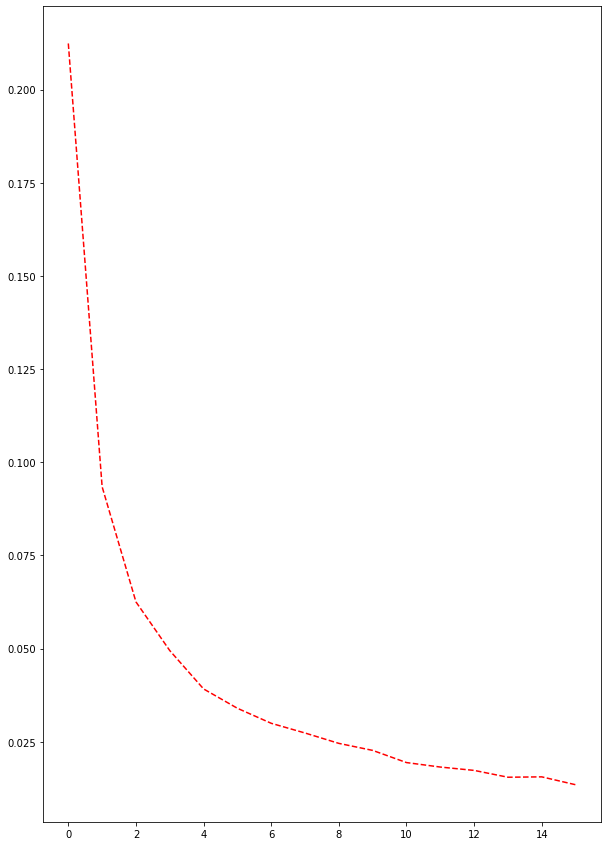

In [13]:
import numpy as np

plt.figure(figsize=(10, 15))
plt.plot(np.arange(16), avg_costs, color='red', linestyle='dashed')
plt.show()

In [14]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9799000024795532
Label:  8
Prediction:  8


C:\Users\admin\workspace\Pytorch\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\admin\workspace\Pytorch\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
